In [ ]:
import librosa
import pandas as pd
from sklearn.utils import class_weight
from librosa.effects import pitch_shift
import os
from sklearn.metrics import classification_report
import pathlib
import random
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from librosa.feature import mfcc, melspectrogram
import scipy.io.wavfile as wav
import tensorflow as tf
import scipy.signal as signal
import keras
from sklearn.model_selection import train_test_split
from keras.models import Model
from research.dataImporting import MLtools
from keras.optimizers import adam_v2
from keras.layers import Input, Conv1D, Conv2D, SeparableConv1D, MaxPooling1D,MaxPooling2D, Flatten, Dense, Dropout, \
    BatchNormalization, Activation, LSTM, Lambda, Reshape, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import keras.backend as K

# Associated Code for Cellphone-Based sUAS Range Estimation: A Deep-Learning Approach
![](experiment_outline.png)
* [Pre-process](#pre-process)
* [Experiment 1](#exp-1)
* [Experiment 2](#exp-2)
Additionals Sections:
* [Regression](#reg)

# Pre-Processing  <a class="anchor" id="pre-process"></a>
## Import data

In [8]:
parent_directory=os.path.abspath(os.path.join(os.getcwd(), ".."))
passes_df=pd.read_csv(parent_directory+"\\flight_directories\\A1_A2_A3_flight_directory.csv")
phone_slots=["Phone_1-1","Phone_1-3","Phone_11","Phone_12","Phone_15","Phone_2-3","Phone_2-4", "Phone_2-5","Phone_27","Phone_28","Phone_29" "Phone_3-1","Phone_3-2","Phone_3-4","Phone_3-5","Phone_30","Phone_5-2","Phone_5-3","Phone_5-4","Phone_6-2","Phone_6-3","Phone_6-4","Phone_6-5","Phone_7-1","Phone_7-2","Phone_8","Phone_9"]
bad_runs=["A3R6P1","A3R4P4","A3R4P5","A3R3P4","A3R3P5"]
good_runs_IF=["A1R1P1","A1R1P2","A1R1P3","A1R1P4","A1R1P5","A2R1P1","A2R1P2","A2R1P3","A2R1P4","A2R1P5","A2R2P1","A2R2P2","A2R2P3","A2R2P4","A2R2P5"]
good_runs_matrice=["A1R2P2","A1R2P3","A1R2P4","A1R2P5","A2R3P1","A2R3P2","A2R4P1","A2R4P2","A2R4P3","A3R3P1","A3R3P2","A3R4P2","A3R4P3","A3R4P5"]
good_runs_phantom=["A2R5P1","A2R5P2","A2R5P3","A2R5P4","A2R5P5","A2R6P1","A2R6P2","A2R6P3","A2R6P4","A2R6P5","A3R5P1","A3R5P2","A3R5P3","A3R5P4","A3R6P1","A3R6P2","A3R6P3","A3R6P4"]
test_runs_matrice=["A2R3P3","A3R3P3"]
notable_col_names=['Pass','Segment','Phone','Lat','Lon','Alt','Range']
eval_runs=["A3R3P2","A3R3P3","A3R4P1","A3R4P3","A3R5P1","A3R5P2","A3R5P4","A3R6P2","A3R6P4"] #test runs from EVP
training_df_raw=pd.read_csv("datasets/0.5s_raw_range_A1_A2_A3_no_overlap.csv")
print(len(training_df_raw))


KeyboardInterrupt



# Classification with raw data:
Run this section if training the 1DCNN that uses raw audio data (4000 samples) for neural network input

In [128]:
raw_x_data=[]
raw_y_data=[]
def rangeFraction(ranges): #Function normalizes ranges
    closest=np.min(ranges)
    return closest*1/ranges

def classFinder(distance):
    if distance<=40 :
        class_val=0
    elif distance<=60:
        class_val=1
    elif distance<=80:
        class_val=2
    else:
        class_val=3
    return class_val

def rangeClosest(ranges): #Function normalizes ranges
    ranges_copy=ranges
    truth=np.zeros(len(ranges))
    #for x in range(0, 2):
    closest=np.argmin(ranges_copy)
    ranges_copy[closest]=10000
    truth[closest]=1
    return truth
for x in passes_df.iterrows():
    row=x[1]
    pass_num=row[0]
    scenario=row[1]
    run_num=row[2]
    start=row[3]
    stop=row[4]
    drone_gps_file=row[5]
    full_name=(str(scenario) + 'R' + str(run_num) + 'P' + str(pass_num)).strip()
    pass_df=training_df_raw.loc[training_df_raw[str(notable_col_names.index('Pass'))] == full_name]
    #pass_df=training_df.loc[training_df["Pass"] == full_name]
    max_segment=pass_df[str(notable_col_names.index('Segment'))].max()
    #max_segment=pass_df["Segment"].max()
    #for i in range(0,max_segment):
    print(full_name)
    if full_name in good_runs_matrice or full_name in good_runs_phantom or full_name in good_runs_IF:
        for phone in phone_slots:
            phone_seg=pass_df.loc[pass_df[str(notable_col_names.index('Phone'))]==phone]
        # frame_df=pass_df.loc[pass_df[str(notable_col_names.index('Segment'))]==i]
        #frame_df=pass_df.loc[pass_df["Segment"]==i]
            twd_frame=[]
            range_frame=[]
        #for phone in phone_slots:
            for i in range(0,max_segment):
                frame_df=phone_seg.loc[phone_seg[str(notable_col_names.index('Segment'))]==i]
                data=np.array(frame_df.iloc[:,8:4008])
                dist=frame_df[str(notable_col_names.index('Range'))]
                if len(np.array(dist)>0):
                    if np.array(dist)[0]<250 and not(38<np.array(dist)[0]<42) and not(58<np.array(dist)[0]<62) and not(78<np.array(dist)[0]<82) :
                        data=data[0]
                        dist=np.array(dist)[0]
                        class_value=classFinder(dist)
                        twd_frame.append(data)
                        range_frame.append(class_value)
            raw_x_data.extend(np.array(twd_frame))
            raw_y_data.extend(np.array(range_frame))

A1R1P1
A1R1P2
A1R1P3
A1R1P4
A1R1P5
A1R2P1
A1R2P2
A1R2P3
A1R2P4
A1R2P5
A2R1P1
A2R1P2
A2R1P3
A2R1P4
A2R1P5
A2R2P1
A2R2P2
A2R2P3
A2R2P4
A2R2P5
A2R3P1
A2R3P2
A2R3P3
A2R4P1
A2R4P2
A2R4P3
A2R5P1
A2R5P2
A2R5P3
A2R5P4
A2R5P5
A2R6P1
A2R6P2
A2R6P3
A2R6P4
A2R6P5
A2R7P1
A2R7P2
A2R7P3
A2R7P4
A2R7P5
A2R8P1
A2R8P2
A2R8P3
A2R8P4
A2R8P5
A3R3P1
A3R3P2
A3R3P3
A3R3P4
A3R3P5
A3R4P1
A3R4P2
A3R4P3
A3R4P4
A3R4P5
A3R5P1
A3R5P2
A3R5P3
A3R5P4
A3R6P1
A3R6P2
A3R6P3
A3R6P4


In [140]:
def subsample_raw(x_data,y_data):
    new_x=[]
    new_y=[]
    rng=np.random.default_rng(12345)
    for x in range(len(x_data)):
        rand_vals=rng.integers(low=1,high=5,size=1)
        if y_data[x]==3 and rand_vals[0]==2:
        #if y_data[x][0]==3 and rand_vals[0]==2:
            new_x.append(x_data[x])
            new_y.append(y_data[x])
        elif y_data[x] != 3:
            new_x.append(x_data[x])
            new_y.append(y_data[x])
    return np.array(new_x), np.array(new_y)
raw_x_data=np.array(raw_x_data)
raw_x_data=np.float32(raw_x_data)
raw_y_data=np.array(raw_y_data)
x_raw,y_raw=subsample_raw(raw_x_data,raw_y_data)
train_feats_raw,test_feats_raw,train_targs_raw,test_targs_raw=train_test_split(x_raw,y_raw,test_size=0.2,shuffle=True,random_state=42)
range_train_targs_raw=train_targs_raw[:]
range_train_targs_oh_raw=tf.keras.utils.to_categorical(range_train_targs_raw,num_classes=4)
range_test_targs_raw=test_targs_raw[:]
range_test_targs_oh_raw=tf.keras.utils.to_categorical(range_test_targs_raw,num_classes=4)

KeyboardInterrupt: 

In [113]:
# 0= matrice, 1=IF, 2=Phantom
if_train_data=[]
if_test_data=[]
matrice_train_data=[]
matrice_test_data=[]
phantom_train_data=[]
phantom_test_data=[]
combined_data=[]
combined_test_data=[]
if_train_targs=[]
if_test_targs=[]
matrice_train_targs=[]
matrice_test_targs=[]
phantom_train_targs=[]
phantom_test_targs=[]
for x in range(len(train_targs_raw)):
    if train_targs_raw[x]==0:
        matrice_train_data.append(train_feats_raw[x])
        matrice_train_targs.append(train_targs_raw[x])
    elif train_targs_raw[x]==1:
        if_train_data.append(train_feats_raw[x])
        if_train_targs.append(train_targs_raw[x])
    elif train_targs_raw[x]==2:
        phantom_train_data.append(train_feats_raw[x])
        phantom_train_targs.append(train_targs_raw[x])

for x in range(len(test_targs_raw)):
    if test_targs_raw[x]==0:
        matrice_test_data.append(test_feats_raw[x])
        matrice_test_targs.append(test_targs_raw[x])
    elif test_targs_raw[x]==1:
        if_test_data.append(test_feats_raw[x])
        if_test_targs.append(test_targs_raw[x])
    elif test_targs_raw[x]==2:
        phantom_test_data.append(test_feats_raw[x])
        phantom_test_targs.append(test_targs_raw[x])



combined_train_data_raw,combined_val_data_raw,combined_train_targs_raw, combined_val_targs_raw=train_test_split(train_feats_raw,train_targs_raw,test_size=0.2,shuffle=True,random_state=42)


# From raw audio data (0.5s frames) to spectrogram dataset (Classification)
Run this section if training the ML models that uses spectrogam data as the input

In [119]:
def confusion_matrix_maker(truth_targs,preds,name):
    #y_true=np.argmax(range_test_targs, axis=-1)
    cm = confusion_matrix(truth_targs, preds)
    class_names = ["<40","40-60","60-80",">80"]
    fig = plt.figure(figsize=(5, 5))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g',cmap='Blues'); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('Predicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(class_names, fontsize = 10)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True', fontsize=20)
    ax.yaxis.set_ticklabels(class_names, fontsize = 10)
    plt.yticks(rotation=0)

    #plt.title('2DCNN Classification PhantomDS Confusion Matrix', fontsize=20)
    plt.savefig(name+".pdf",bbox_inches='tight')
def classFinder(distance):
    if distance<=40 :
        class_val=0
    elif distance<=60:
        class_val=1
    elif distance<=80:
        class_val=2
    else:
        class_val=3
    return class_val

def melspect(audioData, Fs):
    '''
    Converts decoded wav file to MFCC feature space
    @param audioData: Numpy array of decoded audio wav file
    @return MFCC coefficients
    '''
    data= audioData.astype(float)
    # spect = melspectrogram(y=data,sr=Fs, hop_length=1024,n_mels=64, n_fft=2048)
    spect = np.log(melspectrogram(y=data,sr=Fs))

    return spect
x_data=[]
y_data=[]
for x in passes_df.iterrows():
    row=x[1]
    pass_num=row[0]
    scenario=row[1]
    run_num=row[2]
    start=row[3]
    stop=row[4]
    drone_gps_file=row[5]
    full_name=(str(scenario) + 'R' + str(run_num) + 'P' + str(pass_num)).strip()
    pass_df=training_df_raw.loc[training_df_raw[str(notable_col_names.index('Pass'))] == full_name]
    #pass_df=training_df.loc[training_df["Pass"] == full_name]
    max_segment=pass_df[str(notable_col_names.index('Segment'))].max()
    #max_segment=pass_df["Segment"].max()
    #for i in range(0,max_segment):
    print(full_name)
    if full_name in good_runs_IF:
        drone_type=1
    elif full_name in good_runs_matrice:
        drone_type=0
    else:
        drone_type=2
    if full_name in good_runs_matrice or full_name in good_runs_IF or full_name in good_runs_phantom:
        for phone in phone_slots:
            phone_seg=pass_df.loc[pass_df[str(notable_col_names.index('Phone'))]==phone]
            twd_frame=[]
            range_frame=[]
            for i in range(0,max_segment):
                frame_df=phone_seg.loc[phone_seg[str(notable_col_names.index('Segment'))]==i]
                data=np.array(frame_df.iloc[:,8:4008])
                #data=np.array(frame_df.iloc[:,8:16008])
                if np.any(data):
                    mel_data=melspect(data[0],8000)
                dist=frame_df[str(notable_col_names.index('Range'))]
                if len(np.array(dist)>0):
                    if np.array(dist)[0]<250 and  not(38<np.array(dist)[0]<42) and not(58<np.array(dist)[0]<62) and not(78<np.array(dist)[0]<82) :
                        data=data[0]
                        dist=np.array(dist)[0]
                        class_value=classFinder(dist)
                        twd_frame.append(mel_data)
                        range_frame.append([class_value,drone_type,dist])
            x_data.extend(np.array(twd_frame))
            y_data.extend(np.array(range_frame))

A1R1P1
A1R1P2
A1R1P3
A1R1P4
A1R1P5
A1R2P1
A1R2P2
A1R2P3
A1R2P4
A1R2P5
A2R1P1
A2R1P2
A2R1P3
A2R1P4
A2R1P5
A2R2P1
A2R2P2
A2R2P3
A2R2P4
A2R2P5
A2R3P1
A2R3P2
A2R3P3
A2R4P1
A2R4P2
A2R4P3
A2R5P1
A2R5P2
A2R5P3
A2R5P4
A2R5P5
A2R6P1
A2R6P2
A2R6P3
A2R6P4
A2R6P5
A2R7P1
A2R7P2
A2R7P3
A2R7P4
A2R7P5
A2R8P1
A2R8P2
A2R8P3
A2R8P4
A2R8P5
A3R3P1
A3R3P2
A3R3P3
A3R3P4
A3R3P5
A3R4P1
A3R4P2
A3R4P3
A3R4P4
A3R4P5
A3R5P1
A3R5P2
A3R5P3
A3R5P4
A3R6P1
A3R6P2
A3R6P3
A3R6P4


In [120]:
def subsample(x_data,y_data): # this is done to try and balance the class distributions
    new_x=[]
    new_y=[]
    rng=np.random.default_rng(12345)
    for x in range(len(x_data)):
        rand_vals=rng.integers(low=1,high=5,size=1)
        if y_data[x][0]==3 and rand_vals[0]==2: # y_data[x][0] is the range class
            new_x.append(x_data[x])
            new_y.append(y_data[x])
        elif y_data[x][0] != 3:
            new_x.append(x_data[x])
            new_y.append(y_data[x])
    return np.array(new_x), np.array(new_y)
x_data=np.array(x_data)
x_data=np.float32(x_data)
y_data=np.array(y_data)
x__,y__=subsample(x_data,y_data)
train_feats,test_feats,train_targs,test_targs=train_test_split(x__,y__,test_size=0.2,shuffle=True,random_state=42)
class_train_targs=train_targs[:,1]
cont_range_train_targs=train_targs[:,2]
range_train_targs=train_targs[:,0]
class_train_targs_oh=tf.keras.utils.to_categorical(class_train_targs,num_classes=3)
range_train_targs_oh=tf.keras.utils.to_categorical(range_train_targs,num_classes=4)
class_test_targs=test_targs[:,1]
cont_range_test_targs=test_targs[:,2]
range_test_targs=test_targs[:,0]
class_test_targs_oh=tf.keras.utils.to_categorical(class_test_targs,num_classes=3)
range_test_targs_oh=tf.keras.utils.to_categorical(range_test_targs,num_classes=4)

In [121]:
from sklearn.preprocessing import StandardScaler, RobustScaler

scaler=StandardScaler()
X_train = scaler.fit_transform(train_feats.reshape(-1, train_feats.shape[-1])).reshape(train_feats.shape)
X_test = scaler.transform(test_feats.reshape(-1, test_feats.shape[-1])).reshape(test_feats.shape)

In [122]:
train_feats=X_train
test_feats=X_test

(array([5753.,    0.,    0., 2821.,    0.,    0., 3007.,    0.,    0.,
        5447.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

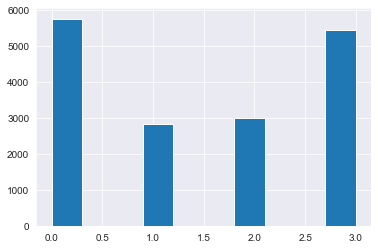

In [49]:
plt.hist(range_train_targs)

Find Distribution of Ranges for Each sUAS Type:

0: <40
1: 40-60
2: 60-80
3: >80

In [118]:
class_count=[0,0,0]
if_ranges=[0,0,0,0]
matrice_ranges=[0,0,0,0]
phantom_ranges=[0,0,0,0]
for x in y__:
    class_count[int(x[1])]+=1
    if int(x[1])== 0:
        matrice_ranges[int(x[0])]+=1
    if int(x[1])== 1:
        if_ranges[int(x[0])]+=1
    if int(x[1])== 2:
        phantom_ranges[int(x[0])]+=1
print(class_count)
print(if_ranges)
print(matrice_ranges)
print(phantom_ranges)

[10256, 2916, 8113]
[1181, 501, 375, 859]
[3859, 1314, 2097, 2986]
[2090, 1700, 1352, 2971]


Split Training Dataset into the three sUAS Types (Matrice, IF, Phantom)
 0: Matrice
 1: IF
 2: Phantom

In [123]:
#
if_train_data=[]
if_test_data=[]
matrice_train_data=[]
matrice_test_data=[]
phantom_train_data=[]
phantom_test_data=[]
combined_data=[]
combined_test_data=[]
if_train_targs=[]
if_test_targs=[]
matrice_train_targs=[]
matrice_test_targs=[]
phantom_train_targs=[]
phantom_test_targs=[]
combined_targs=[]
combined_test_targs=[]
for x in range(len(train_targs)):
    if train_targs[x][1]==0: #Matrice
        matrice_train_data.append(train_feats[x])
        matrice_train_targs.append(train_targs[x][0])
    elif train_targs[x][1]==1: #IF
        if_train_data.append(train_feats[x])
        if_train_targs.append(train_targs[x][0])
    elif train_targs[x][1]==2: #Phantom
        phantom_train_data.append(train_feats[x])
        phantom_train_targs.append(train_targs[x][0])

for x in range(len(test_targs)):
    if test_targs[x][1]==0:
        matrice_test_data.append(test_feats[x])
        matrice_test_targs.append(test_targs[x][0])
    elif test_targs[x][1]==1:
        if_test_data.append(test_feats[x])
        if_test_targs.append(test_targs[x][0])
    elif test_targs[x][1]==2:
        phantom_test_data.append(test_feats[x])
        phantom_test_targs.append(test_targs[x][0])

combined_data.extend(if_train_data)
combined_data.extend(matrice_train_data)
combined_data.extend(phantom_train_data)

combined_targs.extend(if_train_targs)
combined_targs.extend(matrice_train_targs)
combined_targs.extend(phantom_train_targs)


combined_train_data,combined_val_data,combined_train_targs, combined_val_targs=train_test_split(combined_data,combined_targs,test_size=0.2,shuffle=True,random_state=42)

(array([4590.,    0.,    0., 2259.,    0.,    0., 2420.,    0.,    0.,
        4353.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

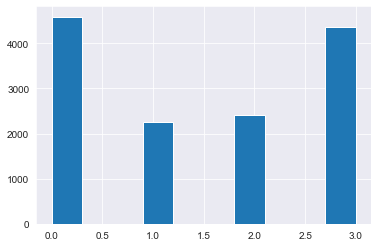

In [46]:
plt.hist(combined_train_targs)

# Plot Spectrogram

In [ ]:
import librosa.display
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(x_data[1500], ref=np.max) #random sample
print(y_data[1500])
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=8000,
                         fmax=4000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
# ax.set(title='Mel-frequency spectrogram')
plt.savefig("melspect.pdf")

# Regression Effort <a class="anchor" id="reg"></a>
Can be ignored if not curious about trying to estimate range as a regression network

(array([ 249., 1526., 3607.,  371.,  374.,  516.,  750., 1181., 1040.,
         593.,  514.,  568.,  292.,  195.,  565.,  312.,  118.,  155.,
         109.,  118.,  125.,  105.,   98.,  113.,   99.,   95.,  106.,
          94.,   91.,  106.,   91.,  116.,  168.,  285.,  490.,  228.,
         208.,  209.,   98.,   93.,   98.,   89.,   82.,  106.,  101.,
          67.,   72.,   86.,   81.,   75.]),
 array([ 22.46454067,  27.01374774,  31.5629548 ,  36.11216187,
         40.66136893,  45.210576  ,  49.75978306,  54.30899012,
         58.85819719,  63.40740425,  67.95661132,  72.50581838,
         77.05502545,  81.60423251,  86.15343958,  90.70264664,
         95.25185371,  99.80106077, 104.35026784, 108.8994749 ,
        113.44868197, 117.99788903, 122.54709609, 127.09630316,
        131.64551022, 136.19471729, 140.74392435, 145.29313142,
        149.84233848, 154.39154555, 158.94075261, 163.48995968,
        168.03916674, 172.58837381, 177.13758087, 181.68678794,
        186.235995  , 19

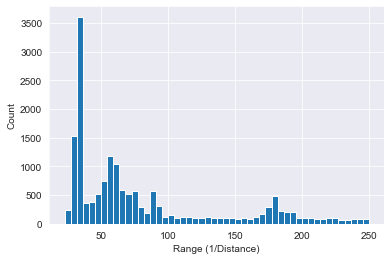

In [45]:
plt.hist(cont_range_train_targs,bins=50)

In [39]:
modelCNN_MCV2=tf.keras.Sequential()
modelCNN_MCV2.add(BatchNormalization(input_shape=(128,8,1)))
modelCNN_MCV2.add(Conv2D(filters=8,kernel_size=(4,4),strides=(1,1),padding='SAME', use_bias=False, name='conv_1'))
modelCNN_MCV2.add(BatchNormalization())
modelCNN_MCV2.add(Activation('relu'))
modelCNN_MCV2.add(MaxPooling2D(2))
modelCNN_MCV2.add(Conv2D(filters=16,kernel_size=(2,2),strides=(2,2), use_bias=False,
                         padding='SAME', name='conv_2'))
modelCNN_MCV2.add(BatchNormalization())
modelCNN_MCV2.add(Activation('relu'))
modelCNN_MCV2.add(Dropout(0.3))
modelCNN_MCV2.add(Conv2D(filters=32,kernel_size=(2,2),strides=(2,2), use_bias=False,
                         padding='SAME', name='conv_3'))
modelCNN_MCV2.add(BatchNormalization())
modelCNN_MCV2.add(Activation('relu'))
modelCNN_MCV2.add(Dropout(0.3))
modelCNN_MCV2.add(Flatten())
modelCNN_MCV2.add(Dense(512, activation='relu', name='dense_2'))
modelCNN_MCV2.add(Dense(256, activation='relu', name='dense_3'))
modelCNN_MCV2.add(Dropout(0.5))
modelCNN_MCV2.add(Dense(1, activation='linear', name='output_range'))

optimizer= tf.keras.optimizers.Adam()
modelCNN_MCV2.compile(loss='mse',optimizer=optimizer,metrics=['mae'])


reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                 verbose=1, patience=20, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                          patience=40, mode='auto', restore_best_weights=True)
modelCNN_MCV2.build(input_shape=(None,128,8,1))
modelCNN_MCV2.summary()
history = modelCNN_MCV2.fit(train_feats, cont_range_train_targs,
                      epochs=200,
                      batch_size=32,
                      shuffle=True,
                      validation_split=0.2,
                      callbacks=[reduceLR, early])

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_112 (Ba  (None, 128, 8, 1)        4         
 tchNormalization)                                               
                                                                 
 conv_1 (Conv2D)             (None, 128, 8, 8)         128       
                                                                 
 batch_normalization_113 (Ba  (None, 128, 8, 8)        32        
 tchNormalization)                                               
                                                                 
 activation_84 (Activation)  (None, 128, 8, 8)         0         
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 64, 4, 8)         0         
 g2D)                                                            
                                                     

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x000001F01CD948B0>
Traceback (most recent call last):
  File "C:\Users\rclendening\AppData\Local\Programs\Python\Python39\lib\weakref.py", line 371, in remove
    self = selfref()
KeyboardInterrupt: 


KeyboardInterrupt: 

In [16]:
preds=modelCNN_MCV2.predict(test_feats)

150/150 [==============================] - 1s 4ms/step


Convert to psuedo-classification

In [17]:
class_vals=[]
for x in preds:
    class_vals.append(classFinder(x))

In [18]:
print(classification_report(range_test_targs,class_vals))

              precision    recall  f1-score   support

         0.0       0.96      0.52      0.67      1496
         1.0       0.34      0.61      0.43       910
         2.0       0.33      0.71      0.45      1067
         3.0       0.85      0.03      0.06      1300

    accuracy                           0.45      4773
   macro avg       0.62      0.47      0.41      4773
weighted avg       0.67      0.45      0.41      4773



# Experiment #2: <a class="anchor" id="exp-2"></a>
Goals:
* Evaluate the performance of the 2DCNN model

* Investigate if the deep learning architecture capable of extracting sUAS-type-agnostic features that generalize sUAS range.

This is done by training the best-performing model architecture on each of the individual datasets and then comparing the performance to the model trained with the Combined dataset. If sUAS range is generalizable, we would expect to see that the model trained with the combined dataset out-performs each of the individual sUAS trained models on that sUAS’s respective testset.



![](exp_2.png)

# A wrapper to re-train the model on Individual sUAS Training Datasets (Used to evaluate IF vs Combined, Matrice vs Combined etc)
Demonstrates the impact that training with exclusively a single sUAS type has on ML model performance. This is experiment #2 in the conference paper titled "Cellphone-Based sUAS Range Estimation: A
Deep-Learning Approach." To compare the impact that training on a single sUAS type has on performance, run the following wrapper function and then run the sequential block of code to see performance statistics.

In [ ]:
training_iterations=1

In [109]:
from sklearn.utils import class_weight
range_weights=class_weight.compute_class_weight('balanced', classes=np.unique(combined_train_targs), y=combined_train_targs)
range_weights={0:range_weights[0], 1:range_weights[1],2:range_weights[2], 3:range_weights[3]}

train_feat_list=[if_train_data,matrice_train_data,phantom_train_data]
train_targ_list=[if_train_targs,matrice_train_targs,phantom_train_targs]
test_feat_list=[if_test_data,matrice_test_data,phantom_test_data]
test_targ_list=[if_test_targs,matrice_test_targs,phantom_test_targs]
f1_score_list=[]
indiv_f1_score_list=[]
balanced_acc_score_list=[]
indiv_balanced_acc_score_list=[]
names=["IF","Matrice","Phantom"]

for x in range(training_iterations):
    modelCNN_MCV2_=tf.keras.Sequential()
    modelCNN_MCV2_.add(BatchNormalization(input_shape=(128,8,1)))
    modelCNN_MCV2_.add(Conv2D(filters=8,kernel_size=(4,4),strides=(1,1),padding='SAME', use_bias=False, name='conv_1'))
    modelCNN_MCV2_.add(BatchNormalization())
    modelCNN_MCV2_.add(Activation('relu'))
    modelCNN_MCV2_.add(MaxPooling2D(2))
    modelCNN_MCV2_.add(Conv2D(filters=16,kernel_size=(2,2),strides=(2,2), use_bias=False,
                             padding='SAME', name='conv_2'))
    modelCNN_MCV2_.add(BatchNormalization())
    modelCNN_MCV2_.add(Activation('relu'))
    modelCNN_MCV2_.add(Dropout(0.3))
    modelCNN_MCV2_.add(Conv2D(filters=32,kernel_size=(2,2),strides=(2,2), use_bias=False,
                             padding='SAME', name='conv_3'))
    modelCNN_MCV2_.add(BatchNormalization())
    modelCNN_MCV2_.add(Activation('relu'))
    modelCNN_MCV2_.add(Dropout(0.3))
    modelCNN_MCV2_.add(Flatten())
    modelCNN_MCV2_.add(Dense(512, activation='relu', name='dense_2'))
    modelCNN_MCV2_.add(Dense(256, activation='relu', name='dense_3'))
    modelCNN_MCV2_.add(Dropout(0.5))
    modelCNN_MCV2_.add(Dense(4, activation='softmax', name='output_range'))

    optimizer= tf.keras.optimizers.Adam()
    modelCNN_MCV2_.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                     verbose=1, patience=20, mode='auto')
    early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                              patience=40, mode='auto', restore_best_weights=True)
    modelCNN_MCV2_.build(input_shape=(None,128,8,1))
    modelCNN_MCV2_.summary()
    single_drone_train_targs_oh=tf.keras.utils.to_categorical(range_train_targs,num_classes=4)
    history = modelCNN_MCV2_.fit(train_feats,single_drone_train_targs_oh,
                          epochs=200,
                          batch_size=32,
                          shuffle=True,
                          class_weight=range_weights,
                          validation_split=0.2,
                          callbacks=[reduceLR, early])
    for test_features in range(len(test_feat_list)):
        score = modelCNN_MCV2_.predict(np.array(test_feat_list[test_features]))
        y_pred = np.argmax(score,axis=-1)
        balanced_acc_score_list.append([balanced_accuracy_score(np.array(test_targ_list[test_features]),y_pred),test_features])
        f1_score_list.append([f1_score(np.array(test_targ_list[test_features]),y_pred,average='macro'),test_features])
        print(classification_report(np.array(test_targ_list[test_features]),y_pred))
        confusion_matrix_maker(np.array(test_targ_list[test_features]),y_pred,names[test_features])


for test_features in range(len(test_feat_list)):
    range_weights=class_weight.compute_class_weight('balanced', classes=np.unique(np.array(train_targ_list[test_features])), y=np.array(train_targ_list[test_features]))
    range_weights={0:range_weights[0], 1:range_weights[1],2:range_weights[2], 3:range_weights[3]}
    print(range_weights)
    for x in range(1):
        modelCNN_MCV2_=tf.keras.Sequential()
        modelCNN_MCV2_.add(BatchNormalization(input_shape=(128,8,1)))
        modelCNN_MCV2_.add(Conv2D(filters=8,kernel_size=(4,4),strides=(1,1),padding='SAME', use_bias=False, name='conv_1'))
        modelCNN_MCV2_.add(BatchNormalization())
        modelCNN_MCV2_.add(Activation('relu'))
        modelCNN_MCV2_.add(MaxPooling2D(2))
        modelCNN_MCV2_.add(Conv2D(filters=16,kernel_size=(2,2),strides=(2,2), use_bias=False,
                                 padding='SAME', name='conv_2'))
        modelCNN_MCV2_.add(BatchNormalization())
        modelCNN_MCV2_.add(Activation('relu'))
        modelCNN_MCV2_.add(Dropout(0.3))
        modelCNN_MCV2_.add(Conv2D(filters=32,kernel_size=(2,2),strides=(2,2), use_bias=False,
                                 padding='SAME', name='conv_3'))
        modelCNN_MCV2_.add(BatchNormalization())
        modelCNN_MCV2_.add(Activation('relu'))
        modelCNN_MCV2_.add(Dropout(0.3))
        modelCNN_MCV2_.add(Flatten())
        modelCNN_MCV2_.add(Dense(512, activation='relu', name='dense_2'))
        modelCNN_MCV2_.add(Dense(256, activation='relu', name='dense_3'))
        modelCNN_MCV2_.add(Dropout(0.5))
        modelCNN_MCV2_.add(Dense(4, activation='softmax', name='output_range'))
        optimizer= tf.keras.optimizers.Adam()
        modelCNN_MCV2_.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
        reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                         verbose=1, patience=20, mode='auto')
        early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                  patience=40, mode='auto', restore_best_weights=True)
        modelCNN_MCV2_.build(input_shape=(None,128,8,1))
        modelCNN_MCV2_.summary()
        single_drone_train_targs_oh=tf.keras.utils.to_categorical(np.array(train_targ_list[test_features]),num_classes=4)
        history = modelCNN_MCV2_.fit(np.array(train_feat_list[test_features]),single_drone_train_targs_oh,
                              epochs=200,
                              batch_size=32,
                              shuffle=True,
                              class_weight=range_weights,
                              validation_split=0.2,
                              callbacks=[reduceLR, early])
        score = modelCNN_MCV2_.predict(np.array(test_feat_list[test_features]))
        y_pred = np.argmax(score,axis=-1)
        indiv_balanced_acc_score_list.append([balanced_accuracy_score(np.array(test_targ_list[test_features]),y_pred),test_features])
        indiv_f1_score_list.append([f1_score(np.array(test_targ_list[test_features]),y_pred,average='macro'),test_features])
        print(classification_report(np.array(test_targ_list[test_features]),y_pred))

Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_235 (Ba  (None, 128, 8, 1)        4         
 tchNormalization)                                               
                                                                 
 conv_1 (Conv2D)             (None, 128, 8, 8)         128       
                                                                 
 batch_normalization_236 (Ba  (None, 128, 8, 8)        32        
 tchNormalization)                                               
                                                                 
 activation_175 (Activation)  (None, 128, 8, 8)        0         
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 64, 4, 8)         0         
 g2D)                                                            
                                                     

Balanced Accuracy Score Comparison of Indiv Trained Models and Combined Trained Models

In [93]:
print(balanced_acc_score_list)
print(indiv_balanced_acc_score_list)
score_counter=[0,0,0]
score_counter_indiv=[0,0,0]
for x in balanced_acc_score_list:
    score_counter[x[1]]+=x[0]

print("Balaned Acc. Performance of model trained with Combined:",np.array(score_counter)/training_iterations)

for x in indiv_balanced_acc_score_list:
    score_counter_indiv[x[1]]+=x[0]

print("Balanced Acc. Performance of model trained with Each Individual sUAS Type (IF,Matrice,Phantom):",np.array(score_counter_indiv)/training_iterations)


Macro F1-Score Comparison of Indiv Trained Models and Combined Trained Models

In [94]:
print(f1_score_list)
print(indiv_f1_score_list)
f1_score_counter_combined=[0,0,0]
f1_score_counter_indiv=[0,0,0]
for x in f1_score_list:
    f1_score_counter_combined[x[1]]+=x[0]

print("Macro-F1 Performance of model trained with Combined:",np.array(f1_score_counter_combined)/training_iterations)

for x in indiv_f1_score_list:
    f1_score_counter_indiv[x[1]]+=x[0]

print("Macro F1-Score Performance of model trained with Each Individual sUAS Type (IF,Matrice,Phantom):",np.array(f1_score_counter_indiv)/training_iterations)

# Experiment #1: <a class="anchor" id="exp-1"></a>
Goal:
* Determine which model architecture is most conducive for this application.

Models are trained and evaluated using a validation set taken from the Combined dataset.

![](exp_1.png)

In [ ]:
range_weights_val=class_weight.compute_class_weight('balanced', classes=np.unique(combined_train_targs), y=combined_train_targs)
range_weights_val={0:range_weights[0], 1:range_weights[1],2:range_weights[2], 3:range_weights[3]}

# CRNN for Classification:

In [96]:
modelCRNN=tf.keras.Sequential()
modelCRNN.add(BatchNormalization(input_shape=(128,8,1)))
modelCRNN.add(Conv2D(filters=8,kernel_size=(2,2),strides=(1,1),padding='SAME', use_bias=False, name='conv_1'))
modelCRNN.add(BatchNormalization())
modelCRNN.add(Activation('relu'))
#modelCRNN.add(MaxPooling2D(2,2))
modelCRNN.add(Conv2D(filters=16,kernel_size=(4,4),strides=(2,1), use_bias=False,
                         padding='SAME', name='conv_2'))
modelCRNN.add(BatchNormalization())
modelCRNN.add(Activation('relu'))
modelCRNN.add(Dropout(0.3))
modelCRNN.add(Conv2D(filters=32,kernel_size=(4,4),strides=(4,1), use_bias=False,
                         padding='SAME', name='conv_3'))
modelCRNN.add(BatchNormalization())
modelCRNN.add(Activation('relu'))
modelCRNN.add(MaxPooling2D((12,1)))
modelCRNN.add(Dropout(0.3))
#modelCRNN.add(Flatten())
modelCRNN.add(Reshape((8,32),input_shape=(1,8,32)))
modelCRNN.add(GRU(32, input_shape=(1,8,32)))
modelCRNN.add(Dense(64, activation='relu', name='dense_3'))
modelCRNN.add(Dropout(0.5))
modelCRNN.add(Dense(4, activation='softmax', name='dense_4'))


optimizer= tf.keras.optimizers.Adam()
modelCRNN.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                 verbose=1, patience=10, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3,
                          patience=40, mode='auto', restore_best_weights=True)
modelCRNN.build(input_shape=(None,128,8,1))
modelCRNN.summary()
single_drone_train_targs_oh=tf.keras.utils.to_categorical(combined_train_targs,num_classes=4)
single_drone_train_data=np.array(combined_train_data)
history = modelCRNN.fit(single_drone_train_data, single_drone_train_targs_oh,
                      epochs=200,
                      batch_size=32,
                      class_weight=range_weights_val,
                      shuffle=True,
                      validation_split=0.2,
                      callbacks=[reduceLR, early])

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_212 (Ba  (None, 128, 8, 1)        4         
 tchNormalization)                                               
                                                                 
 conv_1 (Conv2D)             (None, 128, 8, 8)         32        
                                                                 
 batch_normalization_213 (Ba  (None, 128, 8, 8)        32        
 tchNormalization)                                               
                                                                 
 activation_159 (Activation)  (None, 128, 8, 8)        0         
                                                                 
 conv_2 (Conv2D)             (None, 64, 8, 16)         2048      
                                                                 
 batch_normalization_214 (Ba  (None, 64, 8, 16)      

In [103]:
test_targs_oh=tf.keras.utils.to_categorical(combined_val_targs,num_classes=4)
score = modelCRNN.predict(np.array(combined_val_data))
y_pred = np.argmax(score,axis=-1)
print(classification_report(np.array(combined_val_targs),y_pred))

107/107 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

         0.0       0.87      0.70      0.78      1163
         1.0       0.44      0.53      0.48       562
         2.0       0.48      0.58      0.53       587
         3.0       0.76      0.77      0.77      1094

    accuracy                           0.67      3406
   macro avg       0.64      0.64      0.64      3406
weighted avg       0.70      0.67      0.68      3406



# 1DCNN with Raw inputs

In [114]:
combined_train_data_raw=np.array(combined_train_data_raw)
mean = combined_train_data_raw.mean(axis=0)
std = combined_train_data_raw.std(axis=0)
combined_train_data_raw -= mean
combined_train_data_raw /= std
combined_val_data_raw-=mean
combined_val_data_raw/=std
print(len(combined_train_data_raw))

13622


In [116]:
modelRaw=tf.keras.Sequential()
modelRaw.add(Conv1D(64,input_shape=[4000, 1],kernel_size=80,strides=4,padding='same'))
modelRaw.add(BatchNormalization())
modelRaw.add(Activation('relu'))
modelRaw.add(MaxPooling1D(pool_size=4, strides=None))
modelRaw.add(Conv1D(64,kernel_size=3,strides=2,padding='same'))
modelRaw.add(BatchNormalization())
modelRaw.add(Activation('relu'))
modelRaw.add(MaxPooling1D(pool_size=4, strides=None))
modelRaw.add(Dropout(0.3))
modelRaw.add(Conv1D(128,kernel_size=3,strides=1,padding='same'))
modelRaw.add(BatchNormalization())
modelRaw.add(Activation('relu'))
modelRaw.add(MaxPooling1D(pool_size=4, strides=None))
modelRaw.add(Conv1D(256, kernel_size=3,strides=1,padding='same'))
modelRaw.add(BatchNormalization())
modelRaw.add(Activation('relu'))
modelRaw.add(MaxPooling1D(pool_size=2, strides=None))
modelRaw.add(Lambda(lambda x: K.mean(x, axis=1)))  # Same as GAP for 1D Conv Layer
modelRaw.add(Dense(4, activation='softmax'))
optimizer= tf.keras.optimizers.Adam()
modelRaw.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                 verbose=1, patience=20, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                          patience=40, mode='auto', restore_best_weights=True)
modelRaw.build(input_shape=(None,4000,1))
modelRaw.summary()
train_targs_oh=tf.keras.utils.to_categorical(combined_train_targs_raw,num_classes=4)
history = modelRaw.fit(combined_train_data_raw, train_targs_oh,
                      epochs=200,
                      batch_size=32,
                      shuffle=True,
                      class_weight=range_weights_val,
                      validation_split=0.2,
                      callbacks=[reduceLR, early])

Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 1000, 64)          5184      
                                                                 
 batch_normalization_243 (Ba  (None, 1000, 64)         256       
 tchNormalization)                                               
                                                                 
 activation_182 (Activation)  (None, 1000, 64)         0         
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 250, 64)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 125, 64)           12352     
                                                                 
 batch_normalization_244 (Ba  (None, 125, 64)        

In [117]:
score = modelRaw.predict(combined_val_data_raw)
y_pred = np.argmax(score,axis=-1)
print(classification_report(np.array(combined_val_targs_raw),y_pred))

107/107 [==============================] - 2s 15ms/step
              precision    recall  f1-score   support

           0       0.81      0.66      0.73      1151
           1       0.43      0.52      0.47       590
           2       0.46      0.30      0.36       583
           3       0.63      0.80      0.71      1082

    accuracy                           0.62      3406
   macro avg       0.58      0.57      0.57      3406
weighted avg       0.63      0.62      0.62      3406



# 2DCNN

In [ ]:
modelCNN_MCV2_=tf.keras.Sequential()
modelCNN_MCV2_.add(BatchNormalization(input_shape=(128,8,1)))
modelCNN_MCV2_.add(Conv2D(filters=8,kernel_size=(4,4),strides=(1,1),padding='SAME', use_bias=False, name='conv_1'))
modelCNN_MCV2_.add(BatchNormalization())
modelCNN_MCV2_.add(Activation('relu'))
modelCNN_MCV2_.add(MaxPooling2D(2))
modelCNN_MCV2_.add(Conv2D(filters=16,kernel_size=(2,2),strides=(2,2), use_bias=False,
                         padding='SAME', name='conv_2'))
modelCNN_MCV2_.add(BatchNormalization())
modelCNN_MCV2_.add(Activation('relu'))
modelCNN_MCV2_.add(Dropout(0.3))
modelCNN_MCV2_.add(Conv2D(filters=32,kernel_size=(2,2),strides=(2,2), use_bias=False,
                         padding='SAME', name='conv_3'))
modelCNN_MCV2_.add(BatchNormalization())
modelCNN_MCV2_.add(Activation('relu'))
modelCNN_MCV2_.add(Dropout(0.3))
modelCNN_MCV2_.add(Flatten())
modelCNN_MCV2_.add(Dense(512, activation='relu', name='dense_2'))
modelCNN_MCV2_.add(Dense(256, activation='relu', name='dense_3'))
modelCNN_MCV2_.add(Dropout(0.5))
modelCNN_MCV2_.add(Dense(4, activation='softmax', name='output_range'))

optimizer= tf.keras.optimizers.Adam()
modelCNN_MCV2_.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                 verbose=1, patience=20, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                          patience=40, mode='auto', restore_best_weights=True)
modelCNN_MCV2_.build(input_shape=(None,128,8,1))
modelCNN_MCV2_.summary()
train_targs_oh=tf.keras.utils.to_categorical(combined_train_targs,num_classes=4)
history = modelCNN_MCV2_.fit(combined_train_data,train_targs_oh,
                      epochs=200,
                      batch_size=32,
                      shuffle=True,
                      class_weight=range_weights_val,
                      validation_split=0.2,
                      callbacks=[reduceLR, early])

In [ ]:
score = modelCNN_MCV2_.predict(combined_val_data)
y_pred = np.argmax(score,axis=-1)
print(classification_report(np.array(combined_val_targs),y_pred))